In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
#from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import resnet50
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

Using TensorFlow backend.


In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2913 	 Test size: 655
Image size: 256x256


In [15]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_resnet50(verbose=False, fc_size=256, dropout=None):
    
    from tensorflow.keras.applications import resnet50
    
    resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet50 = models.Sequential()
    resnet50.add(resnet50_base)

    resnet50.add(layers.Flatten())
    if dropout is not None:
        resnet50.add(layers.Dropout(dropout))
    resnet50.add(layers.Dense(fc_size, activation='relu'))
    resnet50.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    resnet50_base.trainable = False
    
    if verbose:
        resnet50_base.summary()
        resnet50.summary()

    return resnet50

In [16]:
resnet50_fe_drop_temp = create_resnet50(verbose=True, dropout=0.5, fc_size=256)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [5]:
resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))

In [6]:
# Instantiate a VGG19 network with custom final layer
resnet50 = models.Sequential()
resnet50.add(resnet50_base)
resnet50.add(layers.Flatten())

resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Dense(1024, activation='relu'))
resnet50.add(layers.Dense(128, activation='relu'))
resnet50.add(layers.Dense(4, activation='softmax'))

resnet50_base.trainable = False

resnet50_fe_drop_128 = resnet50

In [7]:
resnet50_fe_drop_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 157,938,180
Trainable params: 134,350,468
Non-trainable params: 23,587,712
_________________________________

In [8]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('resnet50_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
resnet50_fe_drop_128.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train
history_resnet50_fe_drop_128 = resnet50_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 2.2770 - accuracy: 0.2678
Epoch 00001: val_loss improved from inf to 1.66340, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 35s 2s/step - loss: 2.2545 - accuracy: 0.2681 - val_loss: 1.6634 - val_accuracy: 0.2680
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.7748 - accuracy: 0.3010
Epoch 00002: val_loss improved from 1.66340 to 1.52850, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 1.7781 - accuracy: 0.2999 - val_loss: 1.5285 - val_accuracy: 0.2663
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.6157 - accuracy: 0.3150
Epoch 00003: val_loss did not improve from 1.52850
19/19 [==========================

Epoch 56/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1991 - accuracy: 0.4666
Epoch 00056: val_loss did not improve from 1.31391
19/19 [==============================] - 30s 2s/step - loss: 1.1993 - accuracy: 0.4668 - val_loss: 1.3438 - val_accuracy: 0.3780
Epoch 57/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1984 - accuracy: 0.4698
Epoch 00057: val_loss did not improve from 1.31391
19/19 [==============================] - 30s 2s/step - loss: 1.1973 - accuracy: 0.4689 - val_loss: 1.3373 - val_accuracy: 0.3608
Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1969 - accuracy: 0.4535
Epoch 00058: val_loss did not improve from 1.31391
19/19 [==============================] - 30s 2s/step - loss: 1.1939 - accuracy: 0.4556 - val_loss: 1.3146 - val_accuracy: 0.4055
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1754 - accuracy: 0.4744
Epoch 00059: val_loss improved from 1.31391 to 1.30251, saving model to resn

Epoch 85/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1633 - accuracy: 0.4822
Epoch 00085: val_loss improved from 1.28901 to 1.26318, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 1.1671 - accuracy: 0.4809 - val_loss: 1.2632 - val_accuracy: 0.4278
Epoch 86/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1668 - accuracy: 0.4812
Epoch 00086: val_loss did not improve from 1.26318
19/19 [==============================] - 30s 2s/step - loss: 1.1662 - accuracy: 0.4796 - val_loss: 1.3057 - val_accuracy: 0.4141
Epoch 87/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1374 - accuracy: 0.4871
Epoch 00087: val_loss did not improve from 1.26318
19/19 [==============================] - 30s 2s/step - loss: 1.1423 - accuracy: 0.4843 - val_loss: 1.3147 - val_accuracy: 0.3918
Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1576 - accuracy: 0.4916
Epoch 00088: val_loss 

Epoch 115/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1422 - accuracy: 0.4996
Epoch 00115: val_loss did not improve from 1.26318
19/19 [==============================] - 29s 2s/step - loss: 1.1361 - accuracy: 0.5002 - val_loss: 1.2793 - val_accuracy: 0.4072
Epoch 00115: early stopping


In [15]:
# Save
models.save_model(resnet50_fe_drop_128, 'resnet50_fe_drop_128_4cl_end.h5')

In [11]:
# History of accuracy and loss
tra_loss_fe = history_resnet50_fe_drop_128.history['loss']
tra_acc_fe = history_resnet50_fe_drop_128.history['accuracy']
val_loss_fe = history_resnet50_fe_drop_128.history['val_loss']
val_acc_fe = history_resnet50_fe_drop_128.history['val_accuracy']

In [12]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_fe_drop_128 = models.load_model('resnet50_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet50_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [13]:
print("resnet50 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 115
Epoch [opt]: 85
Valid accuracy [end]: 0.4072
Valid accuracy [opt]: 0.4278
Test accuracy [end]:  0.4687
Test accuracy [opt]:  0.4550
Valid loss [end]: 1.2793
Valid loss [opt]: 1.2632
Test loss [end]:  1.1880
Test loss [opt]:  1.2013


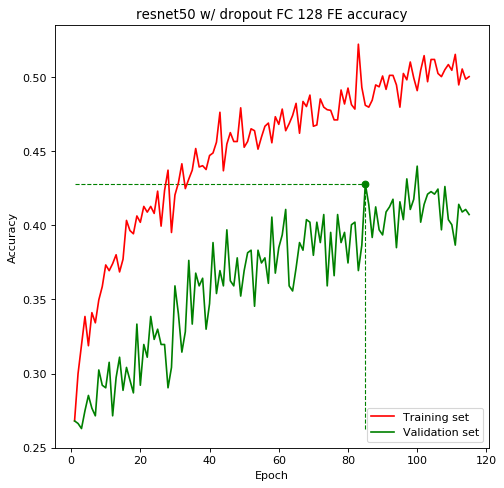

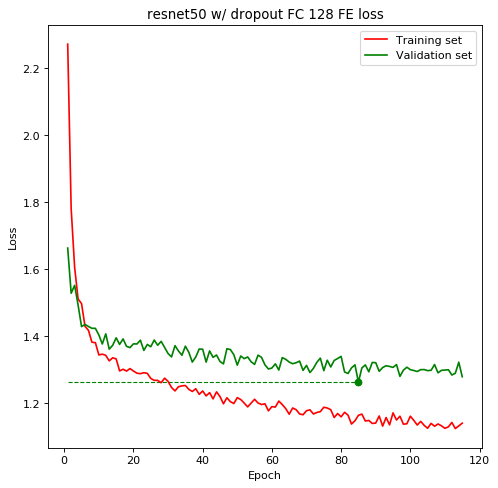

In [14]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [5]:
# 
conv5_block3 = ['conv5_block3_1_conv','conv5_block3_1_bn','conv5_block3_1_relu','conv5_block3_2_conv', 'conv5_block3_2_bn','conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out']                   

resnet50_ft_1layer = models.load_model('resnet50_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in resnet50_ft_1layer.get_layer('resnet50').layers:
    if layer.name in conv5_block3:
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_ft_1layer.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_ft_1layer.summary()
resnet50_ft_1layer.get_layer('resnet50').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 157,938,180
Trainable params: 138,816,132
Non-trainable params: 19,122,048
_________________________________

In [6]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'resnet50_ft_1layer_4cl_best.h5',
        monitor='loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [7]:
# Train
history_ft_1layer = resnet50_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 6.0965 - accuracy: 0.3156
Epoch 00001: loss improved from inf to 6.02359, saving model to resnet50_ft_1layer_4cl_best.h5
11/11 [==============================] - 26s 2s/step - loss: 5.7964 - accuracy: 0.3145 - val_loss: 1.7955 - val_accuracy: 0.3402
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6162 - accuracy: 0.3282
Epoch 00002: loss improved from 6.02359 to 1.61133, saving model to resnet50_ft_1layer_4cl_best.h5
11/11 [==============================] - 23s 2s/step - loss: 1.5975 - accuracy: 0.3336 - val_loss: 1.3333 - val_accuracy: 0.3643
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2680 - accuracy: 0.4109
Epoch 00003: loss improved from 1.61133 to 1.27599, saving model to resnet50_ft_1layer_4cl_best.

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0292 - accuracy: 0.5625
Epoch 00027: loss did not improve from 1.00789
11/11 [==============================] - 22s 2s/step - loss: 1.0271 - accuracy: 0.5646 - val_loss: 1.2710 - val_accuracy: 0.4210
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9681 - accuracy: 0.5946
Epoch 00028: loss improved from 1.00789 to 1.00388, saving model to resnet50_ft_1layer_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 0.9849 - accuracy: 0.5876 - val_loss: 1.4005 - val_accuracy: 0.4519
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0108 - accuracy: 0.5640
Epoch 00029: loss did not improve from 1.00388
11/11 [==============================] - 20s 2s/step - loss: 1.0092 - accuracy: 0.5624 - val_loss: 1.2209 - val_accuracy: 0.4553
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9723 - accuracy: 0.5793
Epoch 00030: loss did not improve fr

In [11]:
# Save
models.save_model(resnet50_ft_1layer, 'resnet50_ft_1layer_4cl_end.h5')

In [12]:
# History of accuracy and loss
tra_loss_fe = history_ft_1layer.history['loss']
tra_acc_fe = history_ft_1layer.history['accuracy']
val_loss_fe = history_ft_1layer.history['val_loss']
val_acc_fe = history_ft_1layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_ft_1layer = models.load_model('resnet50_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet50_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 Fine Tuning

Epoch [end]: 53
Epoch [opt]: 23
Valid accuracy [end]: 0.4485
Valid accuracy [opt]: 0.4347
Test accuracy [end]:  0.4779
Test accuracy [opt]:  0.4779
Valid loss [end]: 1.7995
Valid loss [opt]: 1.2039
Test loss [end]:  1.8512
Test loss [opt]:  1.8512


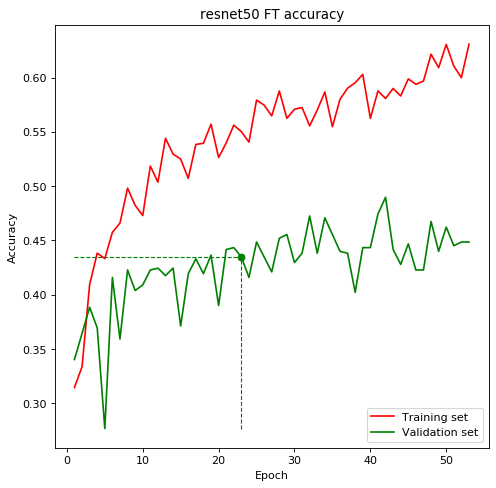

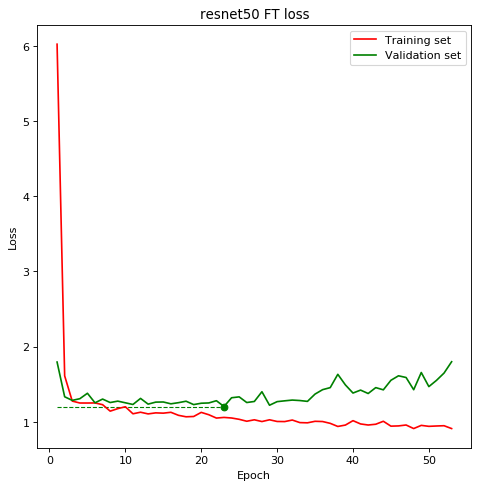

In [13]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [9]:
resnet50_ft_2layer = models.load_model('resnet50_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in resnet50_ft_2layer.get_layer('resnet50').layers:
    if layer.name in ('conv5_block3_3_conv', 'conv5_block3_3_bn'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_ft_2layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

resnet50_ft_2layer.summary()
resnet50_ft_2layer.get_layer('resnet50').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 157,938,180
Trainable params: 135,405,188
Non-trainable params: 22,532,992
_________________________________

In [10]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'resnet50_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [11]:
# Train
history_ft_2layer = resnet50_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1687 - accuracy: 0.4789
Epoch 00001: val_loss improved from inf to 1.24456, saving model to resnet50_ft_2layer_4cl_best.h5
11/11 [==============================] - 24s 2s/step - loss: 1.1682 - accuracy: 0.4808 - val_loss: 1.2446 - val_accuracy: 0.4381
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1355 - accuracy: 0.4969
Epoch 00002: val_loss did not improve from 1.24456
11/11 [==============================] - 21s 2s/step - loss: 1.1367 - accuracy: 0.5007 - val_loss: 1.2819 - val_accuracy: 0.4003
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 1.2090 - accuracy: 0.4792
Epoch 00003: val_loss did not improve from 1.24456
11/11 [==============================] - 20s 2s/step - loss: 1.2012 - accuracy: 0.4813 - val_loss: 1.2770 - val_accuracy: 0.4296
Epoch 4/200
10/11 [=================

Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1441 - accuracy: 0.5055
Epoch 00030: val_loss did not improve from 1.24288
11/11 [==============================] - 21s 2s/step - loss: 1.1437 - accuracy: 0.5092 - val_loss: 1.2776 - val_accuracy: 0.4038
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1303 - accuracy: 0.5039
Epoch 00031: val_loss did not improve from 1.24288
11/11 [==============================] - 21s 2s/step - loss: 1.1336 - accuracy: 0.5014 - val_loss: 1.2659 - val_accuracy: 0.4227
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1570 - accuracy: 0.5038
Epoch 00032: val_loss did not improve from 1.24288
11/11 [==============================] - 20s 2s/step - loss: 1.1499 - accuracy: 0.5042 - val_loss: 1.2620 - val_accuracy: 0.4227
Epoch 33/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1513 - accuracy: 0.4919
Epoch 00033: val_loss did not improve from 1.24288
11/11 [==================

In [12]:
# Save
models.save_model(resnet50_ft_2layer, 'resnet50_ft_2layer_4cl_end.h5')

In [13]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_ft_2layer = models.load_model('resnet50_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet50_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 Fine Tuning

Epoch [end]: 34
Epoch [opt]: 4
Valid accuracy [end]: 0.4467
Valid accuracy [opt]: 0.4313
Test accuracy [end]:  0.4672
Test accuracy [opt]:  0.4473
Valid loss [end]: 1.2468
Valid loss [opt]: 1.2429
Test loss [end]:  1.1868
Test loss [opt]:  1.1973


In [15]:
# Loss and accuracy on the test set
opt_resnet50_ft_2layer = models.load_model('resnet50_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet50_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_ft_2layer.evaluate(test_images, test_labels, verbose=False)


print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)

print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

ResourceExhaustedError: OOM when allocating tensor with shape[131072,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

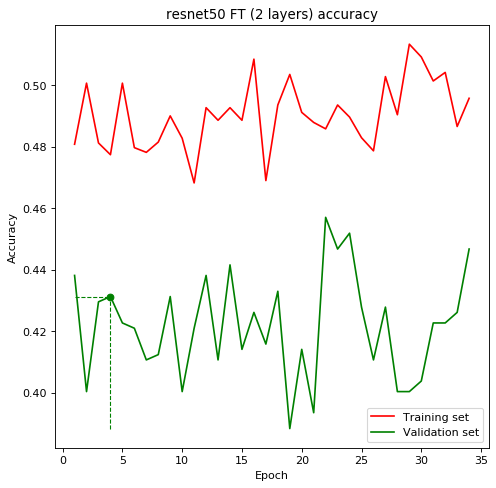

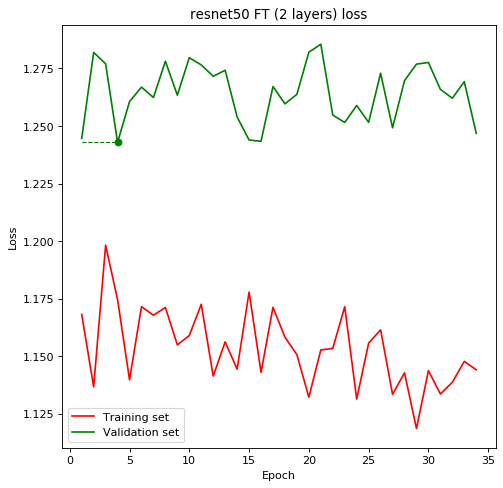

In [14]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();